# MIT-BIH Arrhythmia Classification with AAMI Superclasses

This notebook implements a complete pipeline for ECG beat classification using the MIT-BIH Arrhythmia Database:
- **Loading** raw ECG signals and annotations using WFDB
- **Preprocessing** with beat extraction and AAMI superclass conversion
- **Feature Engineering** with time-domain, statistical, and wavelet features
- **Machine Learning** with Random Forest, XGBoost, SVM, and Logistic Regression
- **Evaluation** with comprehensive metrics and visualizations

## AAMI Beat Classification Standards
| Superclass | Description | Original Labels |
|------------|-------------|-----------------|
| N | Normal | N, L, R, e, j |
| S | Supraventricular | A, a, J, S |
| V | Ventricular | V, E |
| F | Fusion | F |
| Q | Unknown/Paced | /, f, !, Q, P |


## A) Imports


In [1]:
# Standard library
import os
import glob
import json
import warnings
from pathlib import Path
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Signal processing
import wfdb
from scipy import signal
from scipy.stats import skew, kurtosis, entropy
import pywt

# Machine Learning
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Joblib for model saving
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ All imports successful!")


✅ All imports successful!


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATASET_PATH = Path("/Volumes/Crucial X6/medical_ai/ecg2.0")
OUTPUT_PATH = Path("/Volumes/Crucial X6/medical_ai_extra")

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Beat extraction parameters
SAMPLES_BEFORE = 100  # samples before R-peak
SAMPLES_AFTER = 150   # samples after R-peak
BEAT_LENGTH = SAMPLES_BEFORE + SAMPLES_AFTER  # 250 samples per beat

# AAMI Superclass Mapping
AAMI_MAP = {
    # N - Normal beats
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    # S - Supraventricular ectopic beats
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    # V - Ventricular ectopic beats
    'V': 'V', 'E': 'V',
    # F - Fusion beats
    'F': 'F',
    # Q - Unknown/Paced beats
    '/': 'Q', 'f': 'Q', '!': 'Q', 'Q': 'Q', 'P': 'Q'
}

# Class names for display
AAMI_CLASSES = ['N', 'S', 'V', 'F', 'Q']
AAMI_NAMES = {
    'N': 'Normal',
    'S': 'Supraventricular',
    'V': 'Ventricular',
    'F': 'Fusion',
    'Q': 'Unknown/Paced'
}

print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Beat length: {BEAT_LENGTH} samples ({SAMPLES_BEFORE} before + {SAMPLES_AFTER} after R-peak)")


Dataset path: /Volumes/Crucial X6/medical_ai/ecg2.0
Output path: /Volumes/Crucial X6/medical_ai_extra
Beat length: 250 samples (100 before + 150 after R-peak)


## B) Dataset Loading

Load all MIT-BIH records using WFDB library. Each record contains:
- ECG signals (2 channels, 360 Hz sampling rate)
- Beat annotations with sample locations and symbols


In [3]:
def find_records(dataset_path):
    """
    Find all MIT-BIH record files in the dataset directory.
    Returns list of record paths (without extension).
    """
    dataset_path = Path(dataset_path)
    
    # Find all .hea files recursively
    hea_files = list(dataset_path.rglob("*.hea"))
    
    # Extract record paths (remove .hea extension)
    records = []
    for hea_file in hea_files:
        record_path = str(hea_file.with_suffix(''))
        # Check if corresponding .dat and .atr files exist
        dat_file = hea_file.with_suffix('.dat')
        atr_file = hea_file.with_suffix('.atr')
        if dat_file.exists() and atr_file.exists():
            records.append(record_path)
    
    return sorted(records)


def load_record(record_path):
    """
    Load a single MIT-BIH record.
    
    Returns:
        dict with keys: 'record_id', 'signals', 'fs', 'ann_samples', 'ann_symbols'
    """
    try:
        # Read the ECG signal
        record = wfdb.rdrecord(record_path)
        
        # Read annotations
        annotation = wfdb.rdann(record_path, 'atr')
        
        # Extract record ID from path
        record_id = Path(record_path).stem
        
        return {
            'record_id': record_id,
            'signals': record.p_signal,  # Shape: (num_samples, num_channels)
            'fs': record.fs,              # Sampling frequency
            'ann_samples': annotation.sample,  # Sample indices of annotations
            'ann_symbols': annotation.symbol   # Annotation symbols
        }
    except Exception as e:
        print(f"Error loading {record_path}: {e}")
        return None


# Find all records
record_paths = find_records(DATASET_PATH)
print(f"Found {len(record_paths)} records")

# Display first few record paths
for path in record_paths[:5]:
    print(f"  {Path(path).stem}")


Found 71 records
  100
  101
  102
  103
  104


In [4]:
# Load all records
print("Loading all records...")
records_data = []

for i, record_path in enumerate(record_paths):
    data = load_record(record_path)
    if data is not None:
        records_data.append(data)
    if (i + 1) % 10 == 0:
        print(f"  Loaded {i + 1}/{len(record_paths)} records...")

print(f"\n✅ Successfully loaded {len(records_data)} records")

# Display dataset statistics
total_annotations = sum(len(r['ann_symbols']) for r in records_data)
print(f"Total annotations: {total_annotations:,}")

# Check sampling rate consistency
fs_values = set(r['fs'] for r in records_data)
print(f"Sampling rates: {fs_values} Hz")


Loading all records...
  Loaded 10/71 records...
  Loaded 20/71 records...
  Loaded 30/71 records...
  Loaded 40/71 records...
  Loaded 50/71 records...
  Loaded 60/71 records...
  Loaded 70/71 records...

✅ Successfully loaded 71 records
Total annotations: 129,208
Sampling rates: {360} Hz


In [5]:
# Analyze annotation symbol distribution
all_symbols = []
for record in records_data:
    all_symbols.extend(record['ann_symbols'])

symbol_counts = Counter(all_symbols)
print("\nAnnotation symbol distribution:")
print("-" * 40)
for symbol, count in sorted(symbol_counts.items(), key=lambda x: -x[1]):
    aami_class = AAMI_MAP.get(symbol, 'EXCLUDED')
    print(f"  '{symbol}' -> {aami_class}: {count:,} beats")



Annotation symbol distribution:
----------------------------------------
  'N' -> N: 87,261 beats
  'L' -> N: 9,616 beats
  'R' -> N: 8,264 beats
  'V' -> V: 7,892 beats
  '/' -> Q: 7,028 beats
  'A' -> S: 3,064 beats
  '+' -> EXCLUDED: 1,473 beats
  'f' -> Q: 982 beats
  'F' -> F: 825 beats
  '~' -> EXCLUDED: 687 beats
  '"' -> EXCLUDED: 607 beats
  '!' -> Q: 472 beats
  'j' -> N: 235 beats
  'x' -> EXCLUDED: 199 beats
  '|' -> EXCLUDED: 162 beats
  'a' -> S: 154 beats
  'J' -> S: 113 beats
  'E' -> V: 106 beats
  'Q' -> Q: 33 beats
  'e' -> N: 21 beats
  '[' -> EXCLUDED: 6 beats
  ']' -> EXCLUDED: 6 beats
  'S' -> S: 2 beats


## C) Preprocessing

Extract individual beats around R-peaks and convert to AAMI superclasses:
1. Use annotation sample indices as R-peak locations
2. Extract fixed window: 100 samples before, 150 samples after (250 total)
3. Normalize each beat using z-score normalization
4. Use only channel 0 (MLII lead)
5. Map original labels to AAMI superclasses


In [6]:
def extract_beats(record_data, samples_before=100, samples_after=150, channel=0):
    """
    Extract individual beats from a record.
    
    Args:
        record_data: dict with 'signals', 'ann_samples', 'ann_symbols', 'record_id'
        samples_before: number of samples before R-peak
        samples_after: number of samples after R-peak
        channel: ECG channel to use (0 = MLII, 1 = V1/V5)
    
    Returns:
        beats: list of beat waveforms
        labels: list of original annotation symbols
        aami_labels: list of AAMI superclass labels
        record_ids: list of record IDs for each beat
        rr_before: list of RR intervals before each beat
        rr_after: list of RR intervals after each beat
    """
    signals = record_data['signals']
    ann_samples = record_data['ann_samples']
    ann_symbols = record_data['ann_symbols']
    record_id = record_data['record_id']
    fs = record_data['fs']
    
    signal_length = signals.shape[0]
    beat_length = samples_before + samples_after
    
    beats = []
    labels = []
    aami_labels = []
    record_ids = []
    rr_before_list = []
    rr_after_list = []
    
    for i, (sample, symbol) in enumerate(zip(ann_samples, ann_symbols)):
        # Skip if symbol not in AAMI mapping
        if symbol not in AAMI_MAP:
            continue
        
        # Calculate window boundaries
        start = sample - samples_before
        end = sample + samples_after
        
        # Skip if window is out of bounds
        if start < 0 or end > signal_length:
            continue
        
        # Extract beat waveform from specified channel
        beat = signals[start:end, channel]
        
        # Ensure correct length
        if len(beat) != beat_length:
            continue
        
        # Z-score normalization
        beat_mean = np.mean(beat)
        beat_std = np.std(beat)
        if beat_std > 0:
            beat = (beat - beat_mean) / beat_std
        else:
            beat = beat - beat_mean
        
        # Calculate RR intervals
        rr_before = (ann_samples[i] - ann_samples[i-1]) / fs if i > 0 else 0
        rr_after = (ann_samples[i+1] - ann_samples[i]) / fs if i < len(ann_samples) - 1 else 0
        
        beats.append(beat)
        labels.append(symbol)
        aami_labels.append(AAMI_MAP[symbol])
        record_ids.append(record_id)
        rr_before_list.append(rr_before)
        rr_after_list.append(rr_after)
    
    return beats, labels, aami_labels, record_ids, rr_before_list, rr_after_list


# Extract all beats from all records
print("Extracting beats from all records...")
all_beats = []
all_labels = []
all_aami_labels = []
all_record_ids = []
all_rr_before = []
all_rr_after = []

for i, record in enumerate(records_data):
    beats, labels, aami_labels, record_ids, rr_before, rr_after = extract_beats(
        record, 
        samples_before=SAMPLES_BEFORE, 
        samples_after=SAMPLES_AFTER
    )
    all_beats.extend(beats)
    all_labels.extend(labels)
    all_aami_labels.extend(aami_labels)
    all_record_ids.extend(record_ids)
    all_rr_before.extend(rr_before)
    all_rr_after.extend(rr_after)
    
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(records_data)} records...")

# Convert to numpy arrays
X = np.array(all_beats, dtype=np.float32)
y = np.array(all_aami_labels)
record_ids = np.array(all_record_ids)
rr_before = np.array(all_rr_before)
rr_after = np.array(all_rr_after)

print(f"\n✅ Beat extraction complete!")
print(f"X shape: {X.shape} (num_beats, beat_length)")
print(f"y shape: {y.shape}")


Extracting beats from all records...
  Processed 10/71 records...
  Processed 20/71 records...
  Processed 30/71 records...
  Processed 40/71 records...
  Processed 50/71 records...
  Processed 60/71 records...
  Processed 70/71 records...

✅ Beat extraction complete!
X shape: (126005, 250) (num_beats, beat_length)
y shape: (126005,)



AAMI Superclass Distribution:
--------------------------------------------------
  N (Normal         ): 105,343 beats (83.60%)
  S (Supraventricular):  3,333 beats ( 2.65%)
  V (Ventricular    ):  7,994 beats ( 6.34%)
  F (Fusion         ):    824 beats ( 0.65%)
  Q (Unknown/Paced  ):  8,511 beats ( 6.75%)


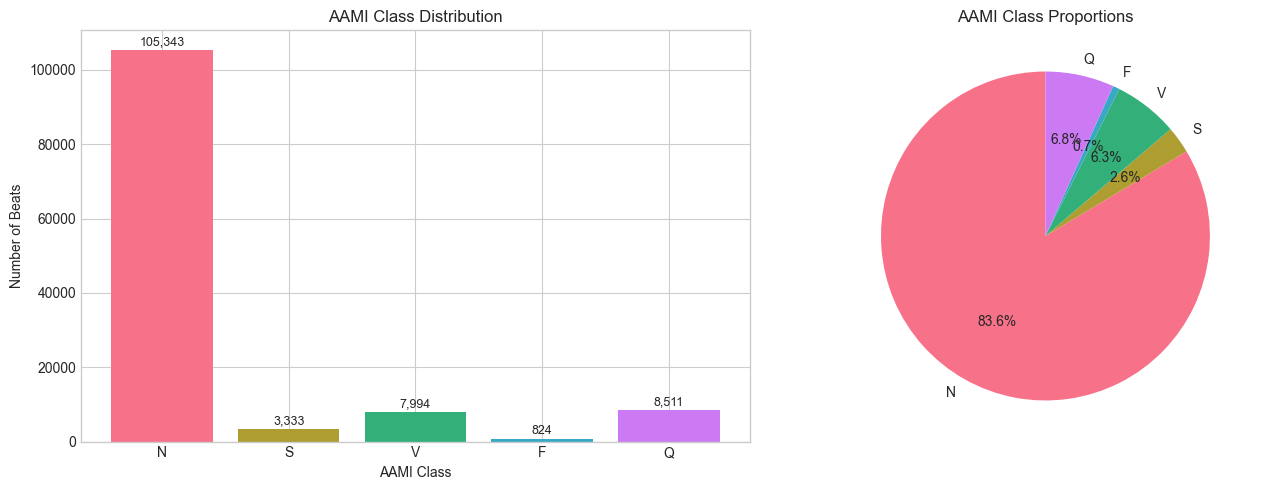


⚠️  Note: Significant class imbalance detected - will use class weights in training


In [7]:
# Display AAMI class distribution
aami_counts = Counter(y)
print("\nAAMI Superclass Distribution:")
print("-" * 50)
total = len(y)
for cls in AAMI_CLASSES:
    count = aami_counts.get(cls, 0)
    pct = 100 * count / total
    print(f"  {cls} ({AAMI_NAMES[cls]:15s}): {count:6,} beats ({pct:5.2f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
counts = [aami_counts.get(cls, 0) for cls in AAMI_CLASSES]
colors = sns.color_palette('husl', len(AAMI_CLASSES))
bars = axes[0].bar(AAMI_CLASSES, counts, color=colors)
axes[0].set_xlabel('AAMI Class')
axes[0].set_ylabel('Number of Beats')
axes[0].set_title('AAMI Class Distribution')
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
                 f'{count:,}', ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(counts, labels=AAMI_CLASSES, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('AAMI Class Proportions')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n⚠️  Note: Significant class imbalance detected - will use class weights in training")


## D) Dataset Splitting (Patient-Based)

Split data by patient (record ID) to prevent data leakage:
- 70% Training
- 15% Validation  
- 15% Testing

This ensures no patient appears in multiple splits.


In [8]:
def patient_split(X, y, record_ids, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split data by patient (record ID) to prevent data leakage.
    
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, 
        train_ids, val_ids, test_ids
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1.0"
    
    # Get unique record IDs
    unique_ids = np.unique(record_ids)
    np.random.seed(random_state)
    np.random.shuffle(unique_ids)
    
    # Calculate split indices
    n_records = len(unique_ids)
    n_train = int(n_records * train_size)
    n_val = int(n_records * val_size)
    
    # Split record IDs
    train_record_ids = set(unique_ids[:n_train])
    val_record_ids = set(unique_ids[n_train:n_train + n_val])
    test_record_ids = set(unique_ids[n_train + n_val:])
    
    # Create masks
    train_mask = np.array([rid in train_record_ids for rid in record_ids])
    val_mask = np.array([rid in val_record_ids for rid in record_ids])
    test_mask = np.array([rid in test_record_ids for rid in record_ids])
    
    # Split data
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    return (X_train, X_val, X_test, y_train, y_val, y_test,
            train_record_ids, val_record_ids, test_record_ids)


# Perform patient-based split
(X_train, X_val, X_test, 
 y_train, y_val, y_test,
 train_ids, val_ids, test_ids) = patient_split(X, y, record_ids)

print("Patient-Based Data Split:")
print("-" * 50)
print(f"Training:   {len(X_train):,} beats from {len(train_ids)} patients")
print(f"Validation: {len(X_val):,} beats from {len(val_ids)} patients")
print(f"Testing:    {len(X_test):,} beats from {len(test_ids)} patients")

# Verify no overlap
assert len(train_ids & val_ids) == 0, "Overlap between train and val!"
assert len(train_ids & test_ids) == 0, "Overlap between train and test!"
assert len(val_ids & test_ids) == 0, "Overlap between val and test!"
print("\n✅ No patient overlap between splits")


Patient-Based Data Split:
--------------------------------------------------
Training:   89,805 beats from 49 patients
Validation: 15,713 beats from 10 patients
Testing:    20,487 beats from 12 patients

✅ No patient overlap between splits


In [9]:
# Display class distribution in each split
print("\nClass distribution per split:")
for name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    counts = Counter(y_split)
    total = len(y_split)
    print(f"\n{name}:")
    for cls in AAMI_CLASSES:
        count = counts.get(cls, 0)
        pct = 100 * count / total if total > 0 else 0
        print(f"  {cls}: {count:,} ({pct:.1f}%)")



Class distribution per split:

Train:
  N: 75,091 (83.6%)
  S: 2,643 (2.9%)
  V: 5,215 (5.8%)
  F: 436 (0.5%)
  Q: 6,420 (7.1%)

Val:
  N: 14,143 (90.0%)
  S: 621 (4.0%)
  V: 933 (5.9%)
  F: 12 (0.1%)
  Q: 4 (0.0%)

Test:
  N: 16,109 (78.6%)
  S: 69 (0.3%)
  V: 1,846 (9.0%)
  F: 376 (1.8%)
  Q: 2,087 (10.2%)


## E) Feature Engineering

Extract classical ML features for each beat:
- **Temporal features**: RR intervals, R-peak amplitude, QRS width
- **Statistical features**: Mean, std, skewness, kurtosis, entropy
- **Wavelet features**: Energy coefficients from DWT decomposition


In [11]:
def compute_wavelet_features(beat, wavelet='db4', level=4):
    """
    Compute wavelet energy coefficients using DWT.
    """
    coeffs = pywt.wavedec(beat, wavelet, level=level)
    energies = []
    for i, coeff in enumerate(coeffs):
        energy = np.sum(coeff ** 2)
        energies.append(energy)
    return energies


def compute_qrs_width(beat, samples_before=100):
    """
    Estimate QRS width by finding zero crossings around R-peak.
    """
    r_idx = samples_before  # R-peak is at center
    
    # Find derivative
    deriv = np.diff(beat)
    
    # Search for QRS boundaries (simplified)
    # Look for significant slope changes
    search_window = 30
    
    # Q point: search backwards from R
    q_start = max(0, r_idx - search_window)
    q_region = deriv[q_start:r_idx]
    if len(q_region) > 0:
        q_idx = q_start + np.argmin(np.abs(q_region))
    else:
        q_idx = r_idx - 10
    
    # S point: search forwards from R
    s_end = min(len(deriv), r_idx + search_window)
    s_region = deriv[r_idx:s_end]
    if len(s_region) > 0:
        s_idx = r_idx + np.argmin(np.abs(s_region))
    else:
        s_idx = r_idx + 10
    
    return s_idx - q_idx


def extract_features(beat, rr_before=0, rr_after=0, samples_before=100):
    """
    Extract comprehensive features from a single beat.
    
    Returns:
        dict of features
    """
    features = {}
    
    # 1. RR interval features
    features['rr_before'] = rr_before
    features['rr_after'] = rr_after
    features['rr_ratio'] = rr_before / rr_after if rr_after > 0 else 0
    
    # 2. R-peak amplitude (at center of beat)
    r_idx = samples_before
    features['r_amplitude'] = beat[r_idx]
    
    # 3. QRS width approximation
    features['qrs_width'] = compute_qrs_width(beat, samples_before)
    
    # 4. Statistical features
    features['mean'] = np.mean(beat)
    features['std'] = np.std(beat)
    features['skewness'] = skew(beat)
    features['kurtosis'] = kurtosis(beat)
    
    # 5. Percentiles
    features['p5'] = np.percentile(beat, 5)
    features['p25'] = np.percentile(beat, 25)
    features['p50'] = np.percentile(beat, 50)
    features['p75'] = np.percentile(beat, 75)
    features['p95'] = np.percentile(beat, 95)
    
    # 6. Range and IQR
    features['range'] = np.max(beat) - np.min(beat)
    features['iqr'] = features['p75'] - features['p25']
    
    # 7. Zero crossings
    zero_crossings = np.where(np.diff(np.signbit(beat)))[0]
    features['zero_crossings'] = len(zero_crossings)
    
    # 8. Entropy (using histogram-based estimation)
    hist, _ = np.histogram(beat, bins=20, density=True)
    hist = hist[hist > 0]  # Remove zeros
    features['entropy'] = entropy(hist)
    
    # 9. Wavelet energy features
    wavelet_energies = compute_wavelet_features(beat)
    for i, energy in enumerate(wavelet_energies):
        features[f'wavelet_energy_{i}'] = energy
    
    # 10. First and second half statistics (morphology)
    mid = len(beat) // 2
    features['first_half_mean'] = np.mean(beat[:mid])
    features['second_half_mean'] = np.mean(beat[mid:])
    features['first_half_std'] = np.std(beat[:mid])
    features['second_half_std'] = np.std(beat[mid:])
    
    # 11. Area under curve (absolute)
    features['auc'] = np.trapz(np.abs(beat))
    
    # 12. Max/min locations (relative to R-peak)
    features['max_loc'] = (np.argmax(beat) - samples_before) / len(beat)
    features['min_loc'] = (np.argmin(beat) - samples_before) / len(beat)
    
    return features


# Test feature extraction on one beat
test_features = extract_features(X_train[0], rr_before[0], rr_after[0])
print(f"Number of features per beat: {len(test_features)}")
print("\nFeature names:")
for i, name in enumerate(test_features.keys()):
    print(f"  {i+1}. {name}")


Number of features per beat: 30

Feature names:
  1. rr_before
  2. rr_after
  3. rr_ratio
  4. r_amplitude
  5. qrs_width
  6. mean
  7. std
  8. skewness
  9. kurtosis
  10. p5
  11. p25
  12. p50
  13. p75
  14. p95
  15. range
  16. iqr
  17. zero_crossings
  18. entropy
  19. wavelet_energy_0
  20. wavelet_energy_1
  21. wavelet_energy_2
  22. wavelet_energy_3
  23. wavelet_energy_4
  24. first_half_mean
  25. second_half_mean
  26. first_half_std
  27. second_half_std
  28. auc
  29. max_loc
  30. min_loc


In [12]:
def extract_features_batch(X_beats, rr_before_arr, rr_after_arr, show_progress=True):
    """
    Extract features from all beats.
    
    Returns:
        DataFrame with features
    """
    all_features = []
    n_beats = len(X_beats)
    
    for i in range(n_beats):
        features = extract_features(
            X_beats[i], 
            rr_before_arr[i] if i < len(rr_before_arr) else 0,
            rr_after_arr[i] if i < len(rr_after_arr) else 0
        )
        all_features.append(features)
        
        if show_progress and (i + 1) % 10000 == 0:
            print(f"  Processed {i + 1:,}/{n_beats:,} beats...")
    
    return pd.DataFrame(all_features)


# We need to re-extract RR intervals for split data
# First, get RR intervals aligned with split data
train_mask = np.array([rid in train_ids for rid in record_ids])
val_mask = np.array([rid in val_ids for rid in record_ids])
test_mask = np.array([rid in test_ids for rid in record_ids])

rr_before_train = rr_before[train_mask]
rr_after_train = rr_after[train_mask]
rr_before_val = rr_before[val_mask]
rr_after_val = rr_after[val_mask]
rr_before_test = rr_before[test_mask]
rr_after_test = rr_after[test_mask]

# Extract features for training set
print("Extracting features for training set...")
df_train = extract_features_batch(X_train, rr_before_train, rr_after_train)
df_train['label'] = y_train
df_train['split'] = 'train'

# Extract features for validation set
print("\nExtracting features for validation set...")
df_val = extract_features_batch(X_val, rr_before_val, rr_after_val)
df_val['label'] = y_val
df_val['split'] = 'val'

# Extract features for test set
print("\nExtracting features for test set...")
df_test = extract_features_batch(X_test, rr_before_test, rr_after_test)
df_test['label'] = y_test
df_test['split'] = 'test'

# Combine all features
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

print(f"\n✅ Feature extraction complete!")
print(f"Total samples: {len(df_all):,}")
print(f"Features per sample: {len(df_all.columns) - 2}")  # Exclude label and split columns


Extracting features for training set...
  Processed 10,000/89,805 beats...
  Processed 20,000/89,805 beats...
  Processed 30,000/89,805 beats...
  Processed 40,000/89,805 beats...
  Processed 50,000/89,805 beats...
  Processed 60,000/89,805 beats...
  Processed 70,000/89,805 beats...
  Processed 80,000/89,805 beats...

Extracting features for validation set...
  Processed 10,000/15,713 beats...

Extracting features for test set...
  Processed 10,000/20,487 beats...
  Processed 20,000/20,487 beats...

✅ Feature extraction complete!
Total samples: 126,005
Features per sample: 30


In [13]:
# Save features to CSV
csv_path = OUTPUT_PATH / 'mitbih_features.csv'
df_all.to_csv(csv_path, index=False)
print(f"✅ Features saved to: {csv_path}")
print(f"   File size: {csv_path.stat().st_size / 1e6:.2f} MB")

# Display feature statistics
print("\nFeature statistics (training set):")
feature_cols = [c for c in df_train.columns if c not in ['label', 'split']]
print(df_train[feature_cols].describe().T[['mean', 'std', 'min', 'max']].head(10))


✅ Features saved to: /Volumes/Crucial X6/medical_ai_extra/mitbih_features.csv
   File size: 48.98 MB

Feature statistics (training set):
                     mean           std           min           max
rr_before    7.869191e-01  2.223339e-01  5.833333e-02  5.872222e+00
rr_after     7.858930e-01  2.214523e-01  0.000000e+00  5.872222e+00
rr_ratio     1.039193e+00  3.412800e-01  0.000000e+00  2.366667e+01
r_amplitude  3.877606e+00  2.462745e+00 -5.155614e+00  8.499606e+00
qrs_width    4.245582e+01  9.054106e+00  1.000000e+00  5.900000e+01
mean        -3.204534e-11  1.275424e-08 -9.155274e-08  9.155274e-08
std          1.000000e+00  2.215022e-08  9.999999e-01  1.000000e+00
skewness     2.169374e+00  1.672699e+00 -3.036184e+00  7.331630e+00
kurtosis     9.384753e+00  7.071006e+00 -1.857620e+00  5.408135e+01
p5          -1.073903e+00  5.360538e-01 -3.059356e+00 -1.449125e-01


## F) Machine Learning Models

Train multiple classifiers with class weights to handle imbalance:
- **Random Forest** (recommended baseline)
- **XGBoost** (gradient boosting)
- **SVM** with RBF kernel
- **Logistic Regression** (simple baseline)


In [14]:
# Prepare feature matrices for ML
feature_cols = [c for c in df_train.columns if c not in ['label', 'split']]

X_train_feat = df_train[feature_cols].values
X_val_feat = df_val[feature_cols].values
X_test_feat = df_test[feature_cols].values

# Encode labels
le = LabelEncoder()
le.fit(AAMI_CLASSES)
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

print(f"Training features shape: {X_train_feat.shape}")
print(f"Classes: {le.classes_}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weight_dict = dict(zip(np.unique(y_train_enc), class_weights))
print(f"\nClass weights: {class_weight_dict}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled = scaler.transform(X_val_feat)
X_test_scaled = scaler.transform(X_test_feat)

print("\n✅ Data prepared for ML training")


Training features shape: (89805, 30)
Classes: ['F' 'N' 'Q' 'S' 'V']

Class weights: {0: 41.194954128440365, 1: 0.23918978306321664, 2: 2.797663551401869, 3: 6.795686719636777, 4: 3.4441035474592523}

✅ Data prepared for ML training


In [15]:
# Dictionary to store models and results
models = {}
results = {}    

# 1. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_enc)
models['Random Forest'] = rf_model
print("  ✓ Random Forest trained")

# 2. XGBoost
print("\nTraining XGBoost...")
# Convert class weights to sample weights for XGBoost
sample_weights = np.array([class_weight_dict[y] for y in y_train_enc])

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train_enc, sample_weight=sample_weights)
models['XGBoost'] = xgb_model
print("  ✓ XGBoost trained")

# 3. SVM with RBF kernel (using subset for speed)
print("\nTraining SVM (RBF)...")
# Use subset if dataset is very large
if len(X_train_scaled) > 50000:
    print("  Using subset of 50,000 samples for SVM training...")
    idx = np.random.choice(len(X_train_scaled), 50000, replace=False)
    X_svm_train = X_train_scaled[idx]
    y_svm_train = y_train_enc[idx]
else:
    X_svm_train = X_train_scaled
    y_svm_train = y_train_enc

svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    random_state=42,
    probability=True  # For ROC curves
)
svm_model.fit(X_svm_train, y_svm_train)
models['SVM (RBF)'] = svm_model
print("  ✓ SVM trained")

# 4. Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
lr_model.fit(X_train_scaled, y_train_enc)
models['Logistic Regression'] = lr_model
print("  ✓ Logistic Regression trained")

print(f"\n✅ All {len(models)} models trained!")


Training Random Forest...
  ✓ Random Forest trained

Training XGBoost...
  ✓ XGBoost trained

Training SVM (RBF)...
  Using subset of 50,000 samples for SVM training...
  ✓ SVM trained

Training Logistic Regression...
  ✓ Logistic Regression trained

✅ All 4 models trained!


## G) Evaluation

Comprehensive evaluation of all models:
- Accuracy, Precision, Recall, F1-score per class
- Macro and Weighted F1-scores
- Confusion matrices
- ROC curves (one-vs-rest)      


In [16]:
def evaluate_model(model, X_test, y_test, model_name, class_names):
    """
    Comprehensive model evaluation.
    
    Returns:
        dict with metrics
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }
    
    # Per-class metrics
    precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    for i, cls in enumerate(class_names):
        metrics[f'precision_{cls}'] = precision_per_class[i] if i < len(precision_per_class) else 0
        metrics[f'recall_{cls}'] = recall_per_class[i] if i < len(recall_per_class) else 0
        metrics[f'f1_{cls}'] = f1_per_class[i] if i < len(f1_per_class) else 0
    
    return metrics, y_pred


# Evaluate all models on test set
print("Evaluating models on test set...")
print("=" * 70)

all_predictions = {}
for model_name, model in models.items():
    metrics, y_pred = evaluate_model(model, X_test_scaled, y_test_enc, model_name, le.classes_)
    results[model_name] = metrics
    all_predictions[model_name] = y_pred
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:     {metrics['accuracy']:.4f}")
    print(f"  Macro F1:     {metrics['f1_macro']:.4f}")
    print(f"  Weighted F1:  {metrics['f1_weighted']:.4f}")

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
print("\n" + "=" * 70)
print("\nModel Comparison Summary:")
print(results_df[['accuracy', 'f1_macro', 'f1_weighted']].round(4))


Evaluating models on test set...

Random Forest:
  Accuracy:     0.9176
  Macro F1:     0.6270
  Weighted F1:  0.8988

XGBoost:
  Accuracy:     0.9675
  Macro F1:     0.6677
  Weighted F1:  0.9605

SVM (RBF):
  Accuracy:     0.9412
  Macro F1:     0.6177
  Weighted F1:  0.9444

Logistic Regression:
  Accuracy:     0.9268
  Macro F1:     0.6470
  Weighted F1:  0.9418


Model Comparison Summary:
                     accuracy  f1_macro f1_weighted
Random Forest        0.917557  0.626972    0.898832
XGBoost              0.967492  0.667669    0.960504
SVM (RBF)            0.941231  0.617667    0.944408
Logistic Regression  0.926783     0.647    0.941816


In [ ]:
# Print detailed classification report for best model (Random Forest)
print("\nDetailed Classification Report (Random Forest):")
print("=" * 70)
print(classification_report(y_test_enc, all_predictions['Random Forest'], 
                           target_names=le.classes_, digits=4))y


In [ ]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test_enc, y_pred)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_,
                ax=axes[idx], cbar=True)
    axes[idx].set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.suptitle('Confusion Matrices (Normalized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrices saved to: {OUTPUT_PATH / 'confusion_matrices.png'}")


In [ ]:
# ROC Curves (One-vs-Rest) for Random Forest
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))

# Get probability predictions from Random Forest
rf_proba = models['Random Forest'].predict_proba(X_test_scaled)

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette('husl', len(le.classes_))

for i, (cls, color) in enumerate(zip(le.classes_, colors)):
    if i < y_test_bin.shape[1]:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], rf_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2,
                label=f'{cls} ({AAMI_NAMES.get(cls, cls)}) - AUC = {roc_auc:.3f}')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves (One-vs-Rest) - Random Forest', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ ROC curves saved to: {OUTPUT_PATH / 'roc_curves.png'}")


In [ ]:
# Feature Importance (Random Forest and XGBoost)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest feature importance
rf_importance = models['Random Forest'].feature_importances_
rf_idx = np.argsort(rf_importance)[-20:]  # Top 20 features

axes[0].barh(range(len(rf_idx)), rf_importance[rf_idx], color='steelblue')
axes[0].set_yticks(range(len(rf_idx)))
axes[0].set_yticklabels([feature_cols[i] for i in rf_idx])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 20 Features', fontweight='bold')

# XGBoost feature importance
xgb_importance = models['XGBoost'].feature_importances_
xgb_idx = np.argsort(xgb_importance)[-20:]

axes[1].barh(range(len(xgb_idx)), xgb_importance[xgb_idx], color='darkorange')
axes[1].set_yticks(range(len(xgb_idx)))
axes[1].set_yticklabels([feature_cols[i] for i in xgb_idx])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 20 Features', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Feature importance saved to: {OUTPUT_PATH / 'feature_importance.png'}")


## H) Save Outputs

Save all artifacts to the output directory:
- Trained model files (.joblib)
- Scaler and label encoder
- Metrics report (JSON)
- All plots


In [ ]:
# Save all models
print("Saving models and artifacts...")
print("=" * 50)

# Create models subdirectory
models_dir = OUTPUT_PATH / 'models'
models_dir.mkdir(exist_ok=True)

# Save each model
for model_name, model in models.items():
    model_filename = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '') + '.joblib'
    model_path = models_dir / model_filename
    joblib.dump(model, model_path)
    print(f"  ✓ Saved: {model_path.name}")

# Save scaler
scaler_path = models_dir / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"  ✓ Saved: {scaler_path.name}")

# Save label encoder
le_path = models_dir / 'label_encoder.joblib'
joblib.dump(le, le_path)
print(f"  ✓ Saved: {le_path.name}")

# Save feature column names
feature_cols_path = models_dir / 'feature_columns.json'
with open(feature_cols_path, 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"  ✓ Saved: {feature_cols_path.name}")

print(f"\n✅ All models saved to: {models_dir}")


In [ ]:
# Save metrics report
metrics_report = {
    'dataset_info': {
        'total_beats': len(y),
        'train_beats': len(y_train),
        'val_beats': len(y_val),
        'test_beats': len(y_test),
        'num_features': len(feature_cols),
        'num_classes': len(AAMI_CLASSES),
        'classes': AAMI_CLASSES,
        'class_distribution': {cls: int(np.sum(y == cls)) for cls in AAMI_CLASSES}
    },
    'preprocessing': {
        'samples_before_r_peak': SAMPLES_BEFORE,
        'samples_after_r_peak': SAMPLES_AFTER,
        'beat_length': BEAT_LENGTH,
        'normalization': 'z-score',
        'channel_used': 0
    },
    'model_results': {name: {k: float(v) if isinstance(v, (np.floating, float)) else v 
                             for k, v in metrics.items()} 
                      for name, metrics in results.items()},
    'best_model': max(results.items(), key=lambda x: x[1]['f1_macro'])[0]
}

# Save as JSON
metrics_path = OUTPUT_PATH / 'metrics_report.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_report, f, indent=2)
print(f"✅ Metrics report saved to: {metrics_path}")

# Also save as readable text
txt_path = OUTPUT_PATH / 'metrics_report.txt'
with open(txt_path, 'w') as f:
    f.write("MIT-BIH AAMI Classification - Results Report\n")
    f.write("=" * 60 + "\n\n")
    
    f.write("DATASET SUMMARY\n")
    f.write("-" * 40 + "\n")
    f.write(f"Total beats: {metrics_report['dataset_info']['total_beats']:,}\n")
    f.write(f"Training: {metrics_report['dataset_info']['train_beats']:,}\n")
    f.write(f"Validation: {metrics_report['dataset_info']['val_beats']:,}\n")
    f.write(f"Testing: {metrics_report['dataset_info']['test_beats']:,}\n")
    f.write(f"Features: {metrics_report['dataset_info']['num_features']}\n\n")
    
    f.write("CLASS DISTRIBUTION\n")
    f.write("-" * 40 + "\n")
    for cls, count in metrics_report['dataset_info']['class_distribution'].items():
        f.write(f"  {cls} ({AAMI_NAMES[cls]}): {count:,}\n")
    
    f.write("\nMODEL RESULTS (Test Set)\n")
    f.write("-" * 40 + "\n")
    for model_name, metrics in results.items():
        f.write(f"\n{model_name}:\n")
        f.write(f"  Accuracy:     {metrics['accuracy']:.4f}\n")
        f.write(f"  Macro F1:     {metrics['f1_macro']:.4f}\n")
        f.write(f"  Weighted F1:  {metrics['f1_weighted']:.4f}\n")
    
    f.write(f"\n\nBEST MODEL: {metrics_report['best_model']}\n")

print(f"✅ Text report saved to: {txt_path}")


## I) Final Summary


In [ ]:
# Final Summary
print("=" * 70)
print("  MIT-BIH AAMI CLASSIFICATION - PIPELINE COMPLETE")
print("=" * 70)

print("\n📊 DATASET:")
print(f"   • Total beats extracted: {len(y):,}")
print(f"   • AAMI classes: {', '.join(AAMI_CLASSES)}")
print(f"   • Features per beat: {len(feature_cols)}")

print("\n🔀 DATA SPLIT (Patient-based):")
print(f"   • Training:   {len(y_train):,} beats ({100*len(y_train)/len(y):.1f}%)")
print(f"   • Validation: {len(y_val):,} beats ({100*len(y_val)/len(y):.1f}%)")
print(f"   • Testing:    {len(y_test):,} beats ({100*len(y_test)/len(y):.1f}%)")

print("\n🤖 MODELS TRAINED:")
for name in models.keys():
    print(f"   • {name}")

print("\n🏆 BEST MODEL PERFORMANCE (Test Set):")
best_model = max(results.items(), key=lambda x: x[1]['f1_macro'])
print(f"   Model: {best_model[0]}")
print(f"   • Accuracy:    {best_model[1]['accuracy']:.4f}")
print(f"   • Macro F1:    {best_model[1]['f1_macro']:.4f}")
print(f"   • Weighted F1: {best_model[1]['f1_weighted']:.4f}")

print("\n📁 OUTPUT FILES:")
print(f"   {OUTPUT_PATH}/")
output_files = list(OUTPUT_PATH.glob('*'))
for f in sorted(output_files):
    if f.is_file():
        size = f.stat().st_size
        if size > 1e6:
            print(f"   ├── {f.name} ({size/1e6:.1f} MB)")
        else:
            print(f"   ├── {f.name} ({size/1e3:.1f} KB)")
    elif f.is_dir():
        print(f"   ├── {f.name}/")
        for sf in sorted(f.glob('*')):
            size = sf.stat().st_size
            if size > 1e6:
                print(f"   │   ├── {sf.name} ({size/1e6:.1f} MB)")
            else:
                print(f"   │   ├── {sf.name} ({size/1e3:.1f} KB)")

print("\n" + "=" * 70)
print("  ✅ Pipeline completed successfully!")
print("=" * 70)
